# Regression with Neural Networks

Imagine that you work for a taxi company, and that one of your customers' biggest complaints is that they don't know how much a ride will cost until it's over. That's because distance is just one of several factors from which taxi fares are calculated. You decide to do something about it by building a mobile app that customers can use when they climb into a taxi to estimate what the fare will be. To provide the smarts for the app, you intend to use the massive amounts of fare data the company has collected over the years to train a neural network. Let's use a portion of a larger taxi-fare dataset from New York City to train the network to predict a fare amount given the time of day, the pickup and dropoff locations, and other information.

## Load and prepare data

Start by loading the dataset and shaping it so that it's suitable for use in machine learning. This dataset is a subset of a much larger dataset containing more than 100 million rows. Recently, the larger dataset was used in Kaggle's [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) competition.

In [3]:
import pandas as pd

df = pd.read_csv('Data/taxi-fares.csv', parse_dates=['pickup_datetime'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00+00:00,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00+00:00,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1


The data requires a fair amount of prep work before it’s useful — something that is not uncommon in machine learning. Use the following statements to transform the raw dataset into one suitable for training.

In [8]:
from math import sqrt
 
df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)
 
for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance
 
df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
 
df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.head()

,fare_amount,day_of_week,pickup_time,distance
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493
9,8.9,3.0,16.0,1.365739


The resulting dataset contains columns for the day of the week (0-6, where 0 corresponds to Monday), the hour of day (0-23), and the distance traveled in miles, and from which outliers have been removed.

# Train a neural network

Now it's time build a neural network and train it with the data prepared in the previous exercise. We'll create two hidden layers with 512 neurons each and an input layer that accepts three values: distance, the day of the week, and the time of day. Since the model is designed to predict a fare amount, the output layer will have one neuron.

In [3]:
pip install tensorflow 

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.3-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.17.0-cp311-cp311-win_amd64.whl.metadata (34 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
 
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

c:\Users\anton\anaconda3\envs\ml_fixed\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,217 (1.01 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Extract the feature columns and the label column and train the model.

In [9]:
x = df.drop('fare_amount', axis=1)
y = df['fare_amount']

hist = model.fit(x, y, validation_split=0.2, epochs=100, batch_size=100)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8932 - mae: 2.8932 - val_loss: 2.3735 - val_mae: 2.3735
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4146 - mae: 2.4146 - val_loss: 2.5276 - val_mae: 2.5276
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3855 - mae: 2.3855 - val_loss: 2.3679 - val_mae: 2.3679
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3677 - mae: 2.3677 - val_loss: 2.3650 - val_mae: 2.3650
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3766 - mae: 2.3766 - val_loss: 2.3573 - val_mae: 2.3573
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3497 - mae: 2.3497 - val_loss: 2.3381 - val_mae: 2.3381
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3888 - mae: 2.3888 - val_loss: 2.3466 - val_mae: 2.3466
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3516 - mae: 2.3516 - val_loss: 2.3457 - val_mae: 2.3457
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

Plot the training accuracy and validation accuracy over time.

[]

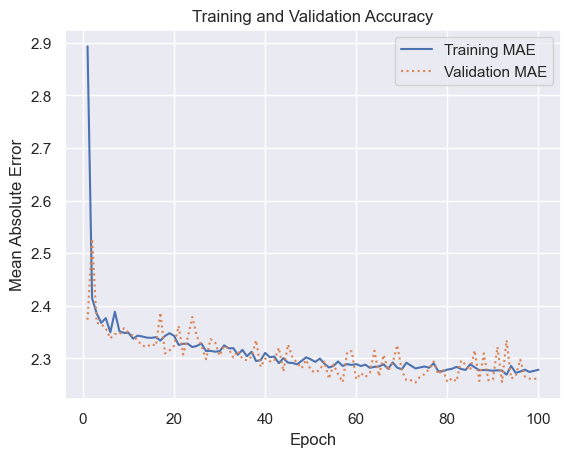

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

Get the coefficient of determination (R2) to determine how accurate the model is.

In [11]:
from sklearn.metrics import r2_score

r2_score(y, model.predict(x))

729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.7453311381805601

## Use the model to predict fare amounts

Finish up by using the trained model to make a pair of predictions. First, estimate what it will cost to hire a taxi for a 2-mile trip at 5:00 p.m. on Friday afternoon.

In [12]:
import numpy as np

model.predict(np.array([[4, 17, 2.0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[10.238603]], dtype=float32)

Now predict the fare amount for a 2-mile trip taken at 5:00 p.m. one day later (on Saturday).

In [13]:
model.predict(np.array([[5, 17, 2.0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[9.934189]], dtype=float32)

Does the model predict a higher or lower fare amount for the same trip on Saturday afternoon? Does this make sense given that the data comes from a New York City cab company?